In [1]:
import pandas as pd
from pathlib import Path
from scipy.stats import gamma
import matplotlib.pyplot as plt
import numpy as np
from ChemostatSimulation import Cell, Chemostat, PRECISION


In [2]:
# Set the parameters

# # Nutrient accumulation
# Cell.critical_nutrient_amount = 10
# Cell.nutrient_accumulation_rate = 1

# # Damage accumulation
Cell.damage_accumulation_exponential_component = 0.05
Cell.damage_accumulation_linear_component = 0.1
Cell.lethal_damage_threshold = 1000
# Cell.damage_survival_dependency = "linear"

# # mutation rates
# Cell.asymmetry_mutation_rate = 0
# Cell.asymmetry_mutation_step = 0.01
# Cell.repair_mutation_rate = 0
# Cell.repair_mutation_step = 0.01

# # lambda_large_lookup
# Cell.lambda_large_lookup_path = f"../tables/lambda_large_lookup_table.csv"
# Cell.lambda_large_lookup = None

# # damage repair
# Cell.damage_repair_mode = "multiplicative"
# Cell.repair_cost_coefficient = 1

Cell.lambda_large_lookup = Cell.load_lookup_table_for_lambda_large()

In [4]:
PRECISION = 3
age = 423
mu = 485.741825162483
x = round(age / mu, PRECISION)

In [8]:
5 * (1 - 1.0000000000000003e-05/1e-05)**0.1

(0.12936606031049927+0.04203358101893526j)

In [ ]:
1.0000000000000003e-05 1e-05 0.1

In [5]:
Cell.lambda_large_lookup.loc[Cell.critical_nutrient_amount, str(x)]

2.09617988642718

In [3]:
def prob_to_reproduce(N, damage, age, damage_dependence=True):
    if damage_dependence:
        return Cell(Chemostat(0, 0, N), None, age=age, damage=damage).prob_of_division_from_lookup_table()
    else:
        return Cell(Chemostat(0, 0, N), None, age=age, damage=0).prob_of_division_from_lookup_table()

def prob_not_to_reproduce_at_age_x(prob, x, N, damage, reproduction_damage_dependence=True):
    if damage <= Cell.lethal_damage_threshold:
        if Cell.damage_survival_dependency == "linear":
            return prob * (1 - damage/Cell.lethal_damage_threshold)*(1 - prob_to_reproduce(N, damage, x, damage_dependence=reproduction_damage_dependence))
        else:
            return prob * (1 - prob_to_reproduce(N, damage, x, damage_dependence=reproduction_damage_dependence))
    else:
        return 0

def prob_to_reproduce_at_age_x(prob, x, N, damage, reproduction_damage_dependence=True):
    if damage <= Cell.lethal_damage_threshold:
        if Cell.damage_survival_dependency == "linear":
            return prob * (1 - damage/Cell.lethal_damage_threshold)*prob_to_reproduce(N, damage, x, damage_dependence=reproduction_damage_dependence)
        else:
            return prob * prob_to_reproduce(N, damage, x, damage_dependence=reproduction_damage_dependence)
    else:
        return 0


def prob_to_reproduce_at_all(N, starting_damage, reproduction_damage_dependence=True):
    deltas = [1e-300, 1e-100]
    ps = [0, 0]
    x = 0
    p_not = 1
    damage = starting_damage
    while deltas[1] > 1e-20 or deltas[0] < deltas[1]:
#         print(damage)
        x += 1
        damage += (Cell.damage_accumulation_exponential_component * damage
                    + Cell.damage_accumulation_linear_component) 
        ps[1] += prob_to_reproduce_at_age_x(p_not, x, N, damage,  reproduction_damage_dependence=reproduction_damage_dependence) 
        p_not = prob_not_to_reproduce_at_age_x(p_not, x, N, damage, reproduction_damage_dependence=reproduction_damage_dependence)
        deltas = [deltas[1], abs(ps[1]-ps[0])]
        ps[0] = ps[1]
#         print(deltas)
    return ps[1]


In [4]:
def fitness(N, total_damage, asymmetry, reproduction_damage_dependence=True):
    one, two = [prob_to_reproduce_at_all(N, total_damage*(1+asymmetry)/2, reproduction_damage_dependence=reproduction_damage_dependence),
                prob_to_reproduce_at_all(N, total_damage*(1-asymmetry)/2, reproduction_damage_dependence=reproduction_damage_dependence)]
    return one + two

def asymmetry_selection_coefficient(N, total_damage, asymmetry=1, background=0, reproduction_damage_dependence=True):
    f_s = fitness(N, total_damage, background, reproduction_damage_dependence)
    f_a = fitness(N, total_damage, asymmetry, reproduction_damage_dependence)
    return 1 - f_s/f_a

def advanced_asymmetry_selection_coefficient(N, asymmetry=1, background=0, reproduction_damage_dependence=True):
    starting_damage = 0
    prob = prob_to_reproduce_at_all(N, starting_damage)
    br = False
    while prob > 0.5:
        starting_damage += starting_damage*Cell.damage_accumulation_exponential_component + Cell.damage_accumulation_linear_component
        prob = prob_to_reproduce_at_all(N, starting_damage)
        if starting_damage >= Cell.lethal_damage_threshold:
            br = True
            starting_damage -= Cell.damage_accumulation_linear_component
            starting_damage /= Cell.damage_accumulation_exponential_component
            break
    f_s = fitness(N, starting_damage, background, reproduction_damage_dependence)
    f_a = fitness(N, starting_damage, asymmetry, reproduction_damage_dependence)
    return 1 - f_s/f_a



In [6]:
N = 55
Cell.damage_accumulation_exponential_component = 0.000000001
Cell.damage_accumulation_linear_component = 0.000001
Cell.damage_survival_dependency = "linear"

||||||||||

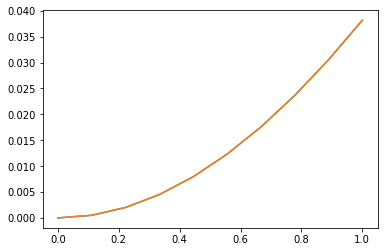

In [8]:
ss_t = []
ss_f = []
sd = np.linspace(0, 1, 10)
for starting_damage in sd:
    ss_t.append(asymmetry_selection_coefficient(N, starting_damage, reproduction_damage_dependence=True))
    ss_f.append(asymmetry_selection_coefficient(N, starting_damage, reproduction_damage_dependence=False))
    print("|", end="")
plt.plot(sd, ss_t, label="reproduction_damage_dependence")
plt.plot(sd, ss_f, label="reproduction_damage_independence")

In [282]:
fitness(55, 200, asymmetry=1), fitness(55, 200, asymmetry=0)

(2.98778125656339e-07, 7.466120287022121e-10)

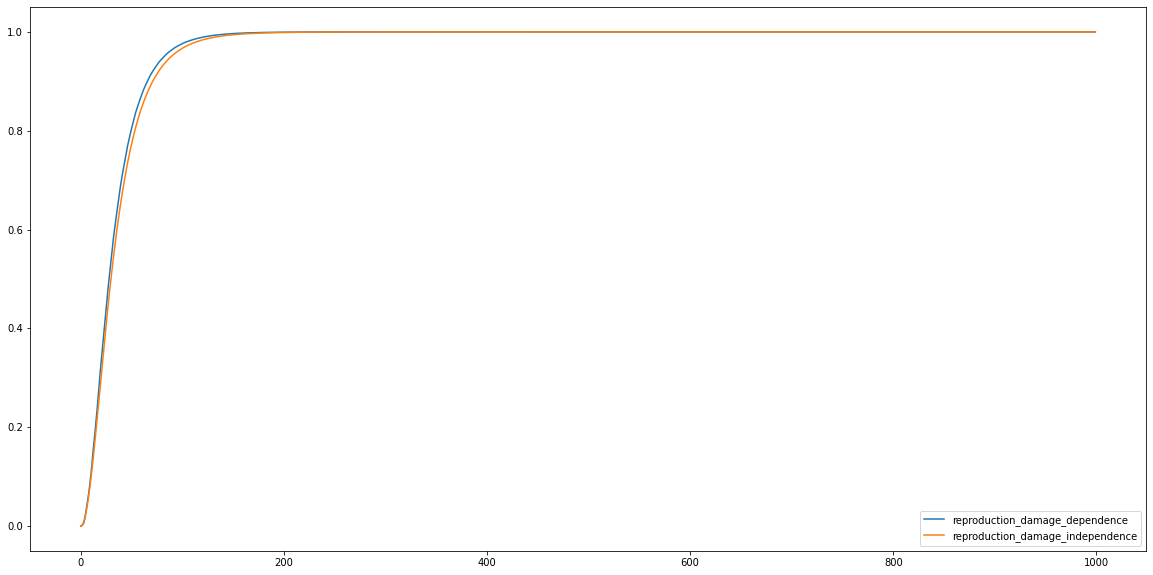

In [279]:
plt.subplots(figsize=(20, 10))
plt.plot(sd, ss_t, label="reproduction_damage_dependence")
plt.plot(sd, ss_f, label="reproduction_damage_independence")
plt.legend()

In [6]:
Cell.damage_accumulation_exponential_component = 0
Cell.damage_accumulation_linear_component = 10
Cell.lethal_damage_threshold = 1000
Cell.damage_survival_dependency = "linear"

In [7]:
Cell.damage_survival_dependency = "threshold"
print("threshold: ", asymmetry_selection_coefficient(1, 100, True))
Cell.damage_survival_dependency = "linear"
print("linear: ", asymmetry_selection_coefficient(1, 100, True))

0.94 0.94
0.94 0.94
0.9299999999999999 0.9299999999999999
0.9299999999999999 0.9299999999999999
0.92 0.92
0.92 0.92
0.91 0.91
0.91 0.91
0.9 0.9
0.9 0.9
0.89 0.89
0.89 0.89
0.88 0.88
0.88 0.88
0.87 0.87
0.87 0.87
0.86 0.86
0.86 0.86
0.85 0.85
0.85 0.85
0.84 0.84
0.84 0.84
0.83 0.83
0.83 0.83
0.8200000000000001 0.8200000000000001
0.8200000000000001 0.8200000000000001
0.81 0.81
0.81 0.81
0.8 0.8
0.8 0.8
0.79 0.79
0.79 0.79
0.78 0.78
0.78 0.78
0.77 0.77
0.77 0.77
0.76 0.76
0.76 0.76
0.75 0.75
0.75 0.75
0.74 0.74
0.74 0.74
0.73 0.73
0.73 0.73
0.72 0.72
0.72 0.72
0.71 0.71
0.71 0.71
0.7 0.7
0.7 0.7
0.69 0.69
0.69 0.69
0.6799999999999999 0.6799999999999999
0.6799999999999999 0.6799999999999999
0.6699999999999999 0.6699999999999999
0.6699999999999999 0.6699999999999999
0.6599999999999999 0.6599999999999999
0.6599999999999999 0.6599999999999999
0.65 0.65
0.65 0.65
0.64 0.64
0.64 0.64
0.63 0.63
0.63 0.63
0.62 0.62
0.62 0.62
0.61 0.61
0.61 0.61
0.6 0.6
0.6 0.6
0.5900000000000001 0.590000000000000

ZeroDivisionError: float division by zero

100.0


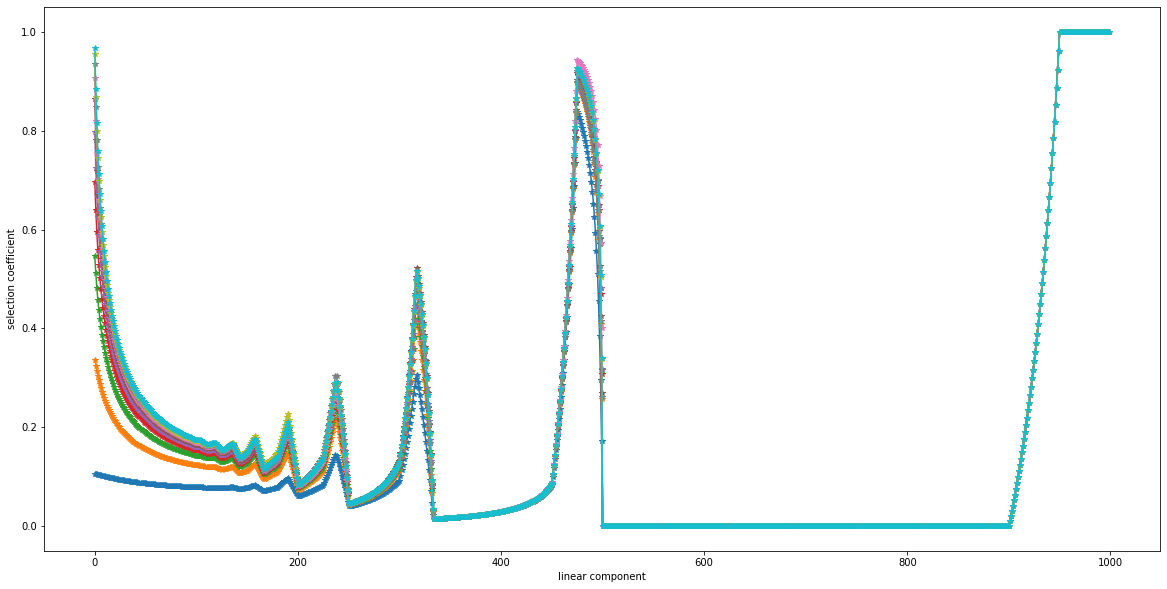

In [14]:
plt.subplots(figsize=(20, 10))
starting_damage = Cell.lethal_damage_threshold/10
print(starting_damage)
lc = list(range(1000))
for N in range(1, 11):
    coefs = []
    for i in lc:
        Cell.damage_accumulation_linear_component = i
        coefs.append(asymmetry_selection_coefficient(N, starting_damage, reproduction_damage_dependence=False))
    plt.plot(lc, coefs, marker="*")
    plt.xlabel("linear component")
    plt.ylabel("selection coefficient")

100.0


Text(0, 0.5, 'selection coefficient')

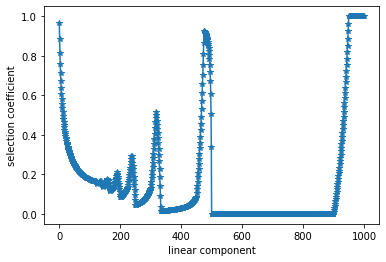

In [128]:

starting_damage = Cell.lethal_damage_threshold/10
print(starting_damage)
lc = list(range(1000))
coefs = []
for i in lc:
    Cell.damage_accumulation_linear_component = i
    coefs.append(asymmetry_selection_coefficient(N, starting_damage, reproduction_damage_dependence=False))
plt.plot(lc, coefs, marker="*")
plt.xlabel("linear component")
plt.ylabel("selection coefficient")

100.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.

1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0
1.0 1.0  |  1.0 1.0


0.9999999999999983 0.9999999999999983  |  0.9999999997852203 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999997852203 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999997852203 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999997852203 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999997852203 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999991816599 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999991816599 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999991816599 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999991816599 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999991816599 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999991816599 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999991816599 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999991816599 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999991816599 1.0
0.9999999999999983 0.9999999999999983  |  0.9999999991816599 1.0
0.9999999999999983 0.9999

0.9999999999864055 0.9999999999864055  |  0.9999998724325398 1.0
0.9999999999864055 0.9999999999864055  |  0.9999998724325398 1.0
0.9999999999864055 0.9999999999864055  |  0.9999998724325398 1.0
0.9999999999864055 0.9999999999864055  |  0.9999998724325398 1.0
0.9999999999864055 0.9999999999864055  |  0.9999998724325398 1.0
0.9999999999864055 0.9999999999864055  |  0.9999998724325398 1.0
0.9999999999864055 0.9999999999864055  |  0.9999998724325398 1.0
0.9999999999864055 0.9999999999864055  |  0.9999998724325398 1.0
0.9999999999864055 0.9999999999864055  |  0.9999998724325398 1.0
0.9999999999864055 0.9999999999864055  |  0.9999998724325398 1.0
0.9999999999864055 0.9999999999864055  |  0.9999998724325398 1.0
0.9999999999864055 0.9999999999864055  |  0.9999998724325398 1.0
0.9999999999864055 0.9999999999864055  |  0.9999995839246426 1.0
0.9999999999864055 0.9999999999864055  |  0.9999995839246426 1.0
0.9999999999864055 0.9999999999864055  |  0.9999995839246426 1.0
0.9999999999864055 0.9999

0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999999969719586  |  0.9999882889365905 1.0
0.9999999969719586 0.9999

0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999995839246426  |  0.9997654921906712 1.0
0.9999995839246426 0.9999

0.9999882889365905 0.9999882889365905  |  0.9985964573214035 0.9999999999999983
0.9999882889365905 0.9999882889365905  |  0.9985964573214035 0.9999999999999983
0.9999882889365905 0.9999882889365905  |  0.9985964573214035 0.9999999999999983
0.9999882889365905 0.9999882889365905  |  0.9985964573214035 0.9999999999999983
0.9999882889365905 0.9999882889365905  |  0.9985964573214035 0.9999999999999983
0.9999882889365905 0.9999882889365905  |  0.9985964573214035 0.9999999999999983
0.9999882889365905 0.9999882889365905  |  0.9985964573214035 0.9999999999999983
0.9999882889365905 0.9999882889365905  |  0.9985964573214035 0.9999999999999983
0.9999882889365905 0.9999882889365905  |  0.9985964573214035 0.9999999999999983
0.9999882889365905 0.9999882889365905  |  0.9985964573214035 0.9999999999999983
0.9999882889365905 0.9999882889365905  |  0.9985964573214035 0.9999999999999983
0.9999882889365905 0.9999882889365905  |  0.9985964573214035 0.9999999999999983
0.9999882889365905 0.9999882889365905  |

0.9999101037043019 0.9999101037043019  |  0.9930050533447145 0.999999999999823
0.9999101037043019 0.9999101037043019  |  0.9930050533447145 0.999999999999823
0.9999101037043019 0.9999101037043019  |  0.9930050533447145 0.999999999999823
0.9999101037043019 0.9999101037043019  |  0.9930050533447145 0.999999999999823
0.9999101037043019 0.9999101037043019  |  0.9930050533447145 0.999999999999823
0.9999101037043019 0.9999101037043019  |  0.9930050533447145 0.999999999999823
0.9999101037043019 0.9999101037043019  |  0.9930050533447145 0.9999999999992277
0.9999101037043019 0.9999101037043019  |  0.9930050533447145 0.9999999999992277
0.9999101037043019 0.9999101037043019  |  0.9930050533447145 0.9999999999992277
0.9999101037043019 0.9999101037043019  |  0.9930050533447145 0.9999999999992277
0.9997654921906712 0.9997654921906712  |  0.9930050533447145 0.9999999999992277
0.9997654921906712 0.9997654921906712  |  0.9930050533447145 0.9999999999992277
0.9997654921906712 0.9997654921906712  |  0.99

0.9985964573214035 0.9985964573214035  |  0.971429395117894 0.9999999999452112
0.9985964573214035 0.9985964573214035  |  0.971429395117894 0.9999999999452112
0.9985964573214035 0.9985964573214035  |  0.971429395117894 0.9999999999452112
0.9985964573214035 0.9985964573214035  |  0.971429395117894 0.9999999999452112
0.9985964573214035 0.9985964573214035  |  0.971429395117894 0.9999999999452112
0.9985964573214035 0.9985964573214035  |  0.971429395117894 0.9999999999452112
0.9985964573214035 0.9985964573214035  |  0.971429395117894 0.9999999999452112
0.9985964573214035 0.9985964573214035  |  0.971429395117894 0.9999999999452112
0.9985964573214035 0.9985964573214035  |  0.971429395117894 0.9999999999452112
0.9985964573214035 0.9985964573214035  |  0.971429395117894 0.9999999999452112
0.9985964573214035 0.9985964573214035  |  0.971429395117894 0.9999999999452112
0.9985964573214035 0.9985964573214035  |  0.971429395117894 0.9999999999452112
0.9985964573214035 0.9985964573214035  |  0.97142939

0.9930050533447145 0.9930050533447145  |  0.9060419233853543 0.9999999969719586
0.9930050533447145 0.9930050533447145  |  0.9060419233853543 0.9999999969719586
0.9930050533447145 0.9930050533447145  |  0.9060419233853543 0.9999999969719586
0.9930050533447145 0.9930050533447145  |  0.9060419233853543 0.9999999969719586
0.9930050533447145 0.9930050533447145  |  0.9060419233853543 0.9999999969719586
0.9930050533447145 0.9930050533447145  |  0.9060419233853543 0.9999999969719586
0.9930050533447145 0.9930050533447145  |  0.9060419233853543 0.9999999969719586
0.9930050533447145 0.9930050533447145  |  0.9060419233853543 0.9999999969719586
0.9930050533447145 0.9930050533447145  |  0.9060419233853543 0.9999999969719586
0.9930050533447145 0.9930050533447145  |  0.9060419233853543 0.9999999969719586
0.9930050533447145 0.9930050533447145  |  0.9060419233853543 0.9999999969719586
0.9930050533447145 0.9930050533447145  |  0.9060419233853543 0.9999999969719586
0.9930050533447145 0.9930050533447145  |

0.9854916035432816 0.9854916035432816  |  0.9060419233853543 0.9999999891281067
0.9854916035432816 0.9854916035432816  |  0.9060419233853543 0.9999999891281067
0.9854916035432816 0.9854916035432816  |  0.9060419233853543 0.9999999891281067
0.9854916035432816 0.9854916035432816  |  0.9060419233853543 0.9999999891281067
0.9854916035432816 0.9854916035432816  |  0.9060419233853543 0.9999999891281067
0.9854916035432816 0.9854916035432816  |  0.9060419233853543 0.9999999891281067
0.9854916035432816 0.9854916035432816  |  0.9060419233853543 0.9999999891281067
0.9854916035432816 0.9854916035432816  |  0.9060419233853543 0.9999999891281067
0.9854916035432816 0.9854916035432816  |  0.9060419233853543 0.9999999891281067
0.9854916035432816 0.9854916035432816  |  0.9060419233853543 0.9999999891281067
0.9854916035432816 0.9854916035432816  |  0.9060419233853543 0.9999999891281067
0.9854916035432816 0.9854916035432816  |  0.9060419233853543 0.9999999891281067
0.9854916035432816 0.9854916035432816  |

0.971429395117894 0.971429395117894  |  0.8438282808187635 0.9999999621583359
0.971429395117894 0.971429395117894  |  0.8438282808187635 0.9999999621583359
0.971429395117894 0.971429395117894  |  0.8438282808187635 0.9999999621583359
0.971429395117894 0.971429395117894  |  0.8438282808187635 0.9999999621583359
0.971429395117894 0.971429395117894  |  0.8438282808187635 0.9999999621583359
0.971429395117894 0.971429395117894  |  0.8438282808187635 0.9999999621583359
0.971429395117894 0.971429395117894  |  0.8438282808187635 0.9999999621583359
0.971429395117894 0.971429395117894  |  0.8438282808187635 0.9999999621583359
0.971429395117894 0.971429395117894  |  0.8438282808187635 0.9999999621583359
0.971429395117894 0.971429395117894  |  0.8438282808187635 0.9999999621583359
0.971429395117894 0.971429395117894  |  0.8438282808187635 0.9999999621583359
0.971429395117894 0.971429395117894  |  0.8438282808187635 0.9999999621583359
0.971429395117894 0.971429395117894  |  0.8438282808187635 0.999

0.971429395117894 0.971429395117894  |  0.7558192462501898 0.9999995839246426
0.971429395117894 0.971429395117894  |  0.7558192462501898 0.9999995839246426
0.971429395117894 0.971429395117894  |  0.7558192462501898 0.9999995839246426
0.971429395117894 0.971429395117894  |  0.7558192462501898 0.9999995839246426
0.971429395117894 0.971429395117894  |  0.7558192462501898 0.9999995839246426
0.971429395117894 0.971429395117894  |  0.7558192462501898 0.9999995839246426
0.971429395117894 0.971429395117894  |  0.7558192462501898 0.9999995839246426
0.971429395117894 0.971429395117894  |  0.7558192462501898 0.9999995839246426
0.971429395117894 0.971429395117894  |  0.7558192462501898 0.9999995839246426
0.971429395117894 0.971429395117894  |  0.7558192462501898 0.9999995839246426
0.971429395117894 0.971429395117894  |  0.7558192462501898 0.9999995839246426
0.971429395117894 0.971429395117894  |  0.7558192462501898 0.9999995839246426
0.971429395117894 0.971429395117894  |  0.7558192462501898 0.999

0.9467036522259447 0.9467036522259447  |  0.7558192462501898 0.9999986884135321
0.9467036522259447 0.9467036522259447  |  0.7558192462501898 0.9999986884135321
0.9467036522259447 0.9467036522259447  |  0.7558192462501898 0.9999986884135321
0.9467036522259447 0.9467036522259447  |  0.7558192462501898 0.9999986884135321
0.9467036522259447 0.9467036522259447  |  0.7558192462501898 0.9999986884135321
0.9467036522259447 0.9467036522259447  |  0.7558192462501898 0.9999986884135321
0.9467036522259447 0.9467036522259447  |  0.7558192462501898 0.9999986884135321
0.9467036522259447 0.9467036522259447  |  0.7558192462501898 0.9999986884135321
0.9467036522259447 0.9467036522259447  |  0.7558192462501898 0.9999986884135321
0.9467036522259447 0.9467036522259447  |  0.7558192462501898 0.9999986884135321
0.9467036522259447 0.9467036522259447  |  0.7558192462501898 0.9999986884135321
0.9467036522259447 0.9467036522259447  |  0.7558192462501898 0.9999986884135321
0.9467036522259447 0.9467036522259447  |

0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999960086896316
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999960086896316
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999960086896316
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999960086896316
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999960086896316
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999960086896316
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999960086896316
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999960086896316
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999960086896316
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999960086896316
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999960086896316
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999960086896316
0.9060419233853543 0.9060419233853543  |

0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999882889365905
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999882889365905
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999882889365905
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999882889365905
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999882889365905
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999882889365905
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999882889365905
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999882889365905
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999882889365905
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999882889365905
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999882889365905
0.9060419233853543 0.9060419233853543  |  0.6415884750809473 0.9999882889365905
0.9060419233853543 0.9060419233853543  |

0.8438282808187635 0.8438282808187635  |  0.5068582245927409 0.9999669118005058
0.8438282808187635 0.8438282808187635  |  0.5068582245927409 0.9999669118005058
0.8438282808187635 0.8438282808187635  |  0.5068582245927409 0.9999669118005058
0.8438282808187635 0.8438282808187635  |  0.5068582245927409 0.9999669118005058
0.8438282808187635 0.8438282808187635  |  0.5068582245927409 0.9999669118005058
0.8438282808187635 0.8438282808187635  |  0.5068582245927409 0.9999669118005058
0.8438282808187635 0.8438282808187635  |  0.5068582245927409 0.9999669118005058
0.8438282808187635 0.8438282808187635  |  0.5068582245927409 0.9999669118005058
0.8438282808187635 0.8438282808187635  |  0.5068582245927409 0.9999669118005058
0.8438282808187635 0.8438282808187635  |  0.5068582245927409 0.9999669118005058
0.8438282808187635 0.8438282808187635  |  0.5068582245927409 0.9999669118005058
0.8438282808187635 0.8438282808187635  |  0.5068582245927409 0.9999669118005058
0.8438282808187635 0.8438282808187635  |

0.7558192462501898 0.7558192462501898  |  0.5068582245927409 0.9999101037043019
0.7558192462501898 0.7558192462501898  |  0.5068582245927409 0.9999101037043019
0.7558192462501898 0.7558192462501898  |  0.5068582245927409 0.9999101037043019
0.7558192462501898 0.7558192462501898  |  0.5068582245927409 0.9999101037043019
0.7558192462501898 0.7558192462501898  |  0.5068582245927409 0.9999101037043019
0.7558192462501898 0.7558192462501898  |  0.5068582245927409 0.9999101037043019
0.7558192462501898 0.7558192462501898  |  0.5068582245927409 0.9999101037043019
0.7558192462501898 0.7558192462501898  |  0.5068582245927409 0.9999101037043019
0.7558192462501898 0.7558192462501898  |  0.5068582245927409 0.9999101037043019
0.7558192462501898 0.7558192462501898  |  0.5068582245927409 0.9999101037043019
0.7558192462501898 0.7558192462501898  |  0.5068582245927409 0.9999101037043019
0.7558192462501898 0.7558192462501898  |  0.5068582245927409 0.9999101037043019
0.7558192462501898 0.7558192462501898  |

0.7558192462501898 0.7558192462501898  |  0.36426228721005843 0.9997654921906712
0.7558192462501898 0.7558192462501898  |  0.36426228721005843 0.9997654921906712
0.7558192462501898 0.7558192462501898  |  0.36426228721005843 0.9997654921906712
0.7558192462501898 0.7558192462501898  |  0.36426228721005843 0.9997654921906712
0.7558192462501898 0.7558192462501898  |  0.36426228721005843 0.9997654921906712
0.7558192462501898 0.7558192462501898  |  0.36426228721005843 0.9997654921906712
0.7558192462501898 0.7558192462501898  |  0.36426228721005843 0.9997654921906712
0.7558192462501898 0.7558192462501898  |  0.36426228721005843 0.9997654921906712
0.7558192462501898 0.7558192462501898  |  0.36426228721005843 0.9997654921906712
0.7558192462501898 0.7558192462501898  |  0.36426228721005843 0.9997654921906712
0.7558192462501898 0.7558192462501898  |  0.36426228721005843 0.9997654921906712
0.7558192462501898 0.7558192462501898  |  0.36426228721005843 0.9997654921906712
0.7558192462501898 0.7558192

0.6415884750809473 0.6415884750809473  |  0.36426228721005843 0.9997654921906712
0.6415884750809473 0.6415884750809473  |  0.36426228721005843 0.9997654921906712
0.6415884750809473 0.6415884750809473  |  0.36426228721005843 0.9997654921906712
0.6415884750809473 0.6415884750809473  |  0.36426228721005843 0.9997654921906712
0.6415884750809473 0.6415884750809473  |  0.36426228721005843 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.36426228721005843 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.36426228721005843 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.36426228721005843 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.36426228721005843 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.36426228721005843 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.36426228721005843 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.36426228721005843 0.9994135504787311
0.6415884750809473 0.6415884

0.6415884750809473 0.6415884750809473  |  0.23114148809174873 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.23114148809174873 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.23114148809174873 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.23114148809174873 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.23114148809174873 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.23114148809174873 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.23114148809174873 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.23114148809174873 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.23114148809174873 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.23114148809174873 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.23114148809174873 0.9994135504787311
0.6415884750809473 0.6415884750809473  |  0.23114148809174873 0.9994135504787311
0.6415884750809473 0.6415884

0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9985964573214035
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9985964573214035
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9985964573214035
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9985964573214035
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9985964573214035
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9985964573214035
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9985964573214035
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9985964573214035
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9985964573214035
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9985964573214035
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9985964573214035
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9985964573214035
0.5068582245927409 0.5068582

0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9967910997018147
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9967910997018147
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9967910997018147
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9967910997018147
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9967910997018147
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9967910997018147
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9967910997018147
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9967910997018147
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9967910997018147
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9967910997018147
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9967910997018147
0.5068582245927409 0.5068582245927409  |  0.23114148809174873 0.9967910997018147
0.5068582245927409 0.5068582

0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9967910997018147
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9967910997018147
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9967910997018147
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9967910997018147
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9967910997018147
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9967910997018147
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9967910997018147
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9967910997018147
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9967910997018147
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9967910997018147
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9967910997018147
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9967910997018147
0.36426228721005

0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9930050533447145
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9930050533447145
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9930050533447145
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9930050533447145
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9930050533447145
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9930050533447145
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9930050533447145
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9930050533447145
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9930050533447145
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9930050533447145
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9930050533447145
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9930050533447145
0.36426228721005

0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9854916035432816
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9854916035432816
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9854916035432816
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9854916035432816
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9854916035432816
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9854916035432816
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9854916035432816
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9854916035432816
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9854916035432816
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9854916035432816
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9854916035432816
0.36426228721005843 0.36426228721005843  |  0.1242058454051308 0.9854916035432816
0.36426228721005

0.23114148809174873 0.23114148809174873  |  0.1242058454051308 0.9854916035432816
0.23114148809174873 0.23114148809174873  |  0.1242058454051308 0.9854916035432816
0.23114148809174873 0.23114148809174873  |  0.1242058454051308 0.9854916035432816
0.23114148809174873 0.23114148809174873  |  0.1242058454051308 0.9854916035432816
0.23114148809174873 0.23114148809174873  |  0.1242058454051308 0.9854916035432816
0.23114148809174873 0.23114148809174873  |  0.1242058454051308 0.9854916035432816
0.23114148809174873 0.23114148809174873  |  0.1242058454051308 0.9854916035432816
0.23114148809174873 0.23114148809174873  |  0.1242058454051308 0.9854916035432816
0.23114148809174873 0.23114148809174873  |  0.1242058454051308 0.9854916035432816
0.23114148809174873 0.23114148809174873  |  0.1242058454051308 0.9854916035432816
0.23114148809174873 0.23114148809174873  |  0.1242058454051308 0.9854916035432816
0.23114148809174873 0.23114148809174873  |  0.1242058454051308 0.9854916035432816
0.23114148809174

0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23

0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23114148809174873 0.23114148809174873  |  0.053047112790718644 0.971429395117894
0.23

Text(0, 0.5, 'selection coefficient')

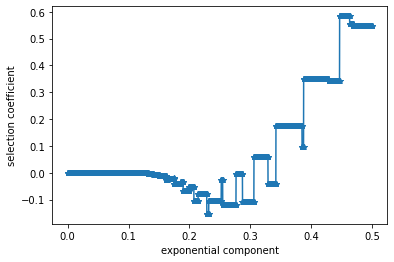

In [244]:
Cell.damage_accumulation_linear_component = 1
starting_damage = Cell.lethal_damage_threshold/10
print(starting_damage)
ec = np.linspace(0, 0.5, 5000)
coefs = []
for i in ec:
    Cell.damage_accumulation_exponential_component = i
    coefs.append(asymmetry_selection_coefficient(N, starting_damage, reproduction_damage_dependence=False))
plt.plot(ec, coefs, marker="*")
plt.xlabel("exponential component")
plt.ylabel("selection coefficient")

100.0


Text(0, 0.5, 'selection coefficient')

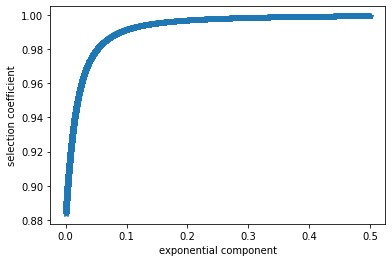

In [131]:
Cell.damage_accumulation_linear_component = 1
starting_damage = Cell.lethal_damage_threshold/10
print(starting_damage)
ec = np.linspace(0, 0.5, 5000)
coefs = []
for i in ec:
    Cell.damage_accumulation_exponential_component = i
    coefs.append(asymmetry_selection_coefficient(N, starting_damage, reproduction_damage_dependence=False))
plt.plot(ec, coefs, marker="*")
plt.xlabel("exponential component")
plt.ylabel("selection coefficient")

In [272]:
N = 100
Cell.damage_survival_dependency = "linear"

In [241]:
1.7167223298853184e-08 + 1.7167223298853184e-08

3.433444659770637e-08

In [242]:
Cell.damage_accumulation_linear_component = 0
# fitness(N, starting_damage, asymmetry=0)
prob_to_reproduce_at_all(N, starting_damage, reproduction_damage_dependence=True)

1.0000000000000002

4.000000000000002

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

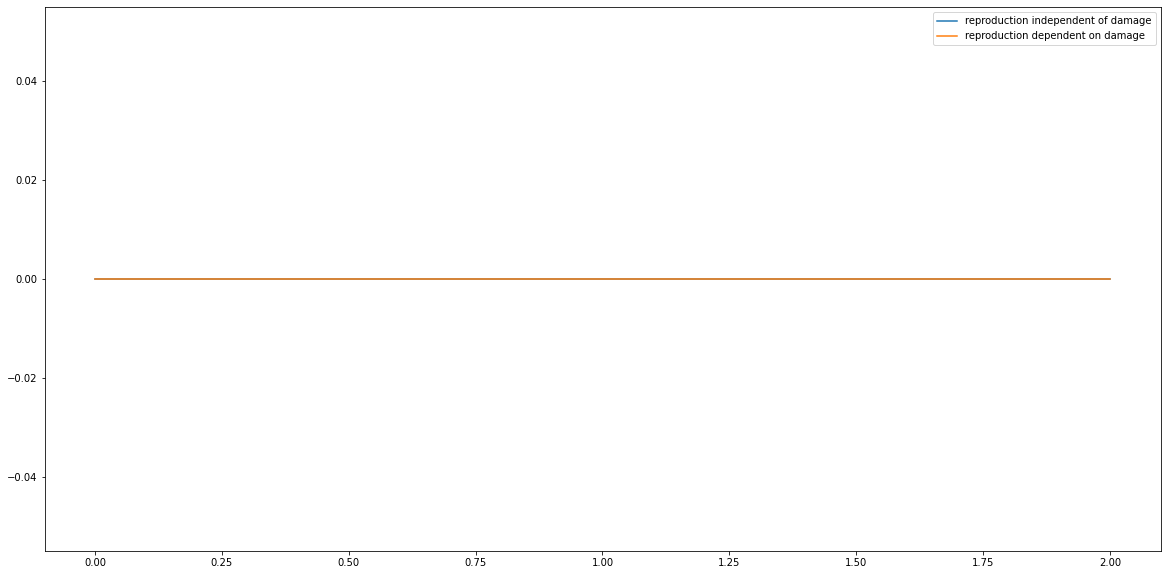

In [273]:
fig, ax = plt.subplots(figsize=(20, 10))
lcs = np.linspace(0.001, 2, 999)
ss_d = []
ss_i = []
for lc in lcs:
    Cell.damage_accumulation_linear_component = lc
    starting_damage = 0
    prob = prob_to_reproduce_at_all(N, starting_damage)
    br = False
    while prob > 0.5:
        starting_damage += Cell.damage_accumulation_linear_component
        prob = prob_to_reproduce_at_all(N, starting_damage)
        if starting_damage >= Cell.lethal_damage_threshold:
            br = True
            break
    if not br:
        ss_d.append(asymmetry_selection_coefficient(N, starting_damage, reproduction_damage_dependence=True))
        ss_i.append(asymmetry_selection_coefficient(N, starting_damage, reproduction_damage_dependence=False))
    print("|", end="")
plt.plot(lcs, ss_d, label="reproduction independent of damage")#, marker="*")
plt.plot(lcs, ss_i, label="reproduction dependent on damage")#, marker="*")
plt.legend()

0.5

In [182]:
N = 1
starting_damage = 2.5
Cell.damage_accumulation_linear_component = 10

In [183]:
Cell.damage_survival_dependency = "linear"

print(Cell.damage_survival_dependency)
print("damage: ", starting_damage)
print("")
print("Reproduction dependent on damage")
print("symmetry: ", round(fitness(N, starting_damage, 0, reproduction_damage_dependence=True), 5))
print("asymmetry: ", round(fitness(N, starting_damage, 1, reproduction_damage_dependence=True), 5))
print("s: ", round(asymmetry_selection_coefficient(N, starting_damage, reproduction_damage_dependence=True), 5))

print("\n")
print("Reproduction independent of damage")
print("symmetry: ", round(fitness(N, starting_damage, 0, reproduction_damage_dependence=False), 5))
print("asymmetry: ", round(fitness(N, starting_damage, 1, reproduction_damage_dependence=False), 5))
print("s: ", round(asymmetry_selection_coefficient(N, starting_damage, reproduction_damage_dependence=False), 5))

linear
damage:  2.5

Reproduction dependent on damage
symmetry:  0.90312
asymmetry:  0.90345
s:  0.00036


Reproduction independent of damage
symmetry:  1.06221
asymmetry:  1.06233
s:  0.00012


In [147]:
# print(fitness(N, Cell.lethal_damage_threshold/10*0, 0))
# print(fitness(N, Cell.lethal_damage_threshold/10*0, 1))
# print("")
Cell.damage_survival_dependency = "threshold"
print(Cell.damage_survival_dependency)
print("damage: ", starting_damage)
print("")
print("Reproduction dependent on damage")
print("symmetry: ", round(fitness(N, starting_damage, 0, reproduction_damage_dependence=True), 5))
print("asymmetry: ", round(fitness(N, starting_damage, 1, reproduction_damage_dependence=True), 5))
print("\n")
print("Reproduction independent of damage")
print("symmetry: ", round(fitness(N, starting_damage, 0, reproduction_damage_dependence=False), 5))
print("asymmetry: ", round(fitness(N, starting_damage, 1, reproduction_damage_dependence=False), 5))


threshold
damage:  10.0

Reproduction dependent on damage
symmetry:  2.0
asymmetry:  2.0


Reproduction independent of damage
symmetry:  2.0
asymmetry:  2.0


In [20]:
Cell.damage_accumulation_exponential_component = 0.05
Cell.damage_accumulation_linear_component = 1
Cell.lethal_damage_threshold = 1000
Cell.damage_survival_dependency = "linear"

In [21]:
starting_damage = 0
N = 10
ages = list(range(1, 1000))
daecs = np.linspace(0, 0.1, 20)
fitness_a, fitness_s = [], []
for daec in daecs:
    Cell.damage_accumulation_exponential_component = daec
    fitness_a.append(fitness(N, Cell.lethal_damage_threshold/100, 1))
    fitness_s.append(fitness(N, Cell.lethal_damage_threshold/100, 0))    

0.0989 0.989
0.0989 0.989
0.0988 0.988
0.0988 0.988
0.0987 0.987
0.0987 0.987
0.0986 0.986
0.0986 0.986
0.0985 0.985
0.0985 0.985
0.0984 0.984
0.0984 0.984
0.0983 0.983
0.0983 0.983
0.0982 0.982
0.0982 0.982
0.09809999999999999 0.981
0.09809999999999999 0.981
0.098 0.98
0.098 0.98
0.0979 0.979
0.0979 0.979
0.0978 0.978
0.0978 0.978
0.0977 0.977
0.0977 0.977
0.09759999999999999 0.976
0.09759999999999999 0.976
0.0975 0.975
0.0975 0.975
0.0974 0.974
0.0974 0.974
0.0973 0.973
0.0973 0.973
0.0972 0.972
0.0972 0.972
0.09709999999999999 0.971
0.09709999999999999 0.971
0.097 0.97
0.097 0.97
0.0969 0.969
0.0969 0.969
0.0968 0.968
0.0968 0.968
0.0967 0.967
0.0967 0.967
0.09659999999999999 0.966
0.09659999999999999 0.966
0.0965 0.965
0.0965 0.965
0.0964 0.964
0.0964 0.964
0.0963 0.963
0.0963 0.963
0.0962 0.962
0.0962 0.962
0.09609999999999999 0.961
0.09609999999999999 0.961
0.096 0.96
0.096 0.96
0.0959 0.959
0.0959 0.959
0.0958 0.958
0.0958 0.958
0.0957 0.957
0.0957 0.957
0.09559999999999999 0.95

0.09363544839573444 0.9363544839573444
0.09340145783564464 0.9340145783564464
0.09340145783564464 0.9340145783564464
0.09316254115850033 0.9316254115850032
0.09316254115850033 0.9316254115850032
0.09291859465657401 0.92918594656574
0.09291859465657401 0.92918594656574
0.09266951243881767 0.9266951243881767
0.09266951243881767 0.9266951243881767
0.09241518638489805 0.9241518638489805
0.09241518638489805 0.9241518638489805
0.09215550609826431 0.9215550609826432
0.09215550609826431 0.9215550609826432
0.09189035885822779 0.9189035885822778
0.09189035885822779 0.9189035885822778
0.09161962957103258 0.9161962957103258
0.09161962957103258 0.9161962957103258
0.09134320071989642 0.9134320071989642
0.09134320071989642 0.9134320071989642
0.0910609523139995 0.910609523139995
0.0910609523139995 0.910609523139995
0.09077276183639948 0.9077276183639948
0.09077276183639948 0.9077276183639948
0.09047850419085 0.9047850419085001
0.09047850419085 0.9047850419085001
0.09017805164749948 0.9017805164749948


0.09859407704046334 0.9859407704046335
0.09839048271712905 0.9839048271712906
0.09839048271712905 0.9839048271712906
0.09817188670681225 0.9817188670681225
0.09817188670681225 0.9817188670681225
0.09793718362205105 0.9793718362205105
0.09793718362205105 0.9793718362205105
0.09768518662578113 0.9768518662578113
0.09768518662578113 0.9768518662578113
0.09741462142978605 0.9741462142978605
0.09741462142978605 0.9741462142978605
0.0971241198509282 0.9712411985092819
0.0971241198509282 0.9712411985092819
0.09681221289257554 0.9681221289257553
0.09681221289257554 0.9681221289257553
0.09647732331623898 0.9647732331623898
0.09647732331623898 0.9647732331623898
0.09611775766585659 0.961177576658566
0.09611775766585659 0.961177576658566
0.09573169770439341 0.957316977043934
0.09573169770439341 0.957316977043934
0.09531719121945396 0.9531719121945397
0.09531719121945396 0.9531719121945397
0.09487214215141374 0.9487214215141373
0.09487214215141374 0.9487214215141373
0.09439429999414947 0.943942999

In [22]:
daec=0
dlc=0
print(fitness(dlt/100, 0, daec, dalc, dlt, N, nar, nca))
print(fitness(dlt/100, 1, daec, dalc, dlt, N, nar, nca))

NameError: name 'dlt' is not defined

In [23]:
fitness_a

[0.05184392003871615,
 0.03740121554841256,
 0.026842639622127587,
 0.019259518563249436,
 0.013840465775426488,
 0.009983480973902822,
 0.007276456985268613,
 0.0053335125058376984,
 0.003941010901271162,
 0.002942230301126496,
 0.0022148392477281593,
 0.001681759887286589,
 0.0012887010037134746,
 0.0009961804796226076,
 0.0007781408483157061,
 0.0006115483221942281,
 0.0004842104747692187,
 0.0003867044419673211,
 0.00030949095735435903,
 0.0002512145085294149]

In [24]:
fitness_s

[0.04901547388450012,
 0.03481657345586716,
 0.02449279347926257,
 0.017160666670928273,
 0.012024419680228115,
 0.008448624567760203,
 0.005972332618553169,
 0.00424465950433564,
 0.003040854185586674,
 0.0021937563040672244,
 0.001597206376069102,
 0.0011766856699807298,
 0.0008729263401323481,
 0.0006503703232983387,
 0.000490301319521851,
 0.0003727504784202442,
 0.00028540152956537984,
 0.00021953579813180924,
 0.00017095648750288357,
 0.00013361074041374859]

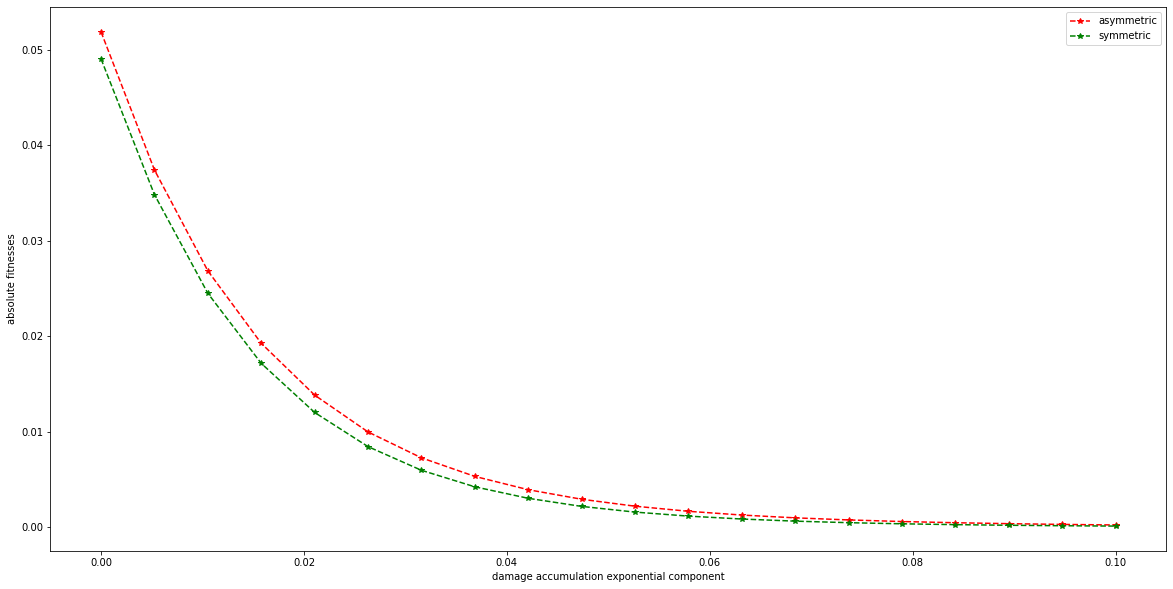

In [26]:
# Absolute Fitnesses
plt.subplots(figsize=(20, 10))
plt.plot(daecs, fitness_a, color="red", label="asymmetric", marker="*", linestyle="--")
plt.plot(daecs, fitness_s, color="green", label="symmetric", marker="*", linestyle="--")
plt.xlabel('damage accumulation exponential component')
plt.ylabel('absolute fitnesses')
plt.legend()

Text(0, 0.5, 'selection coefficient')

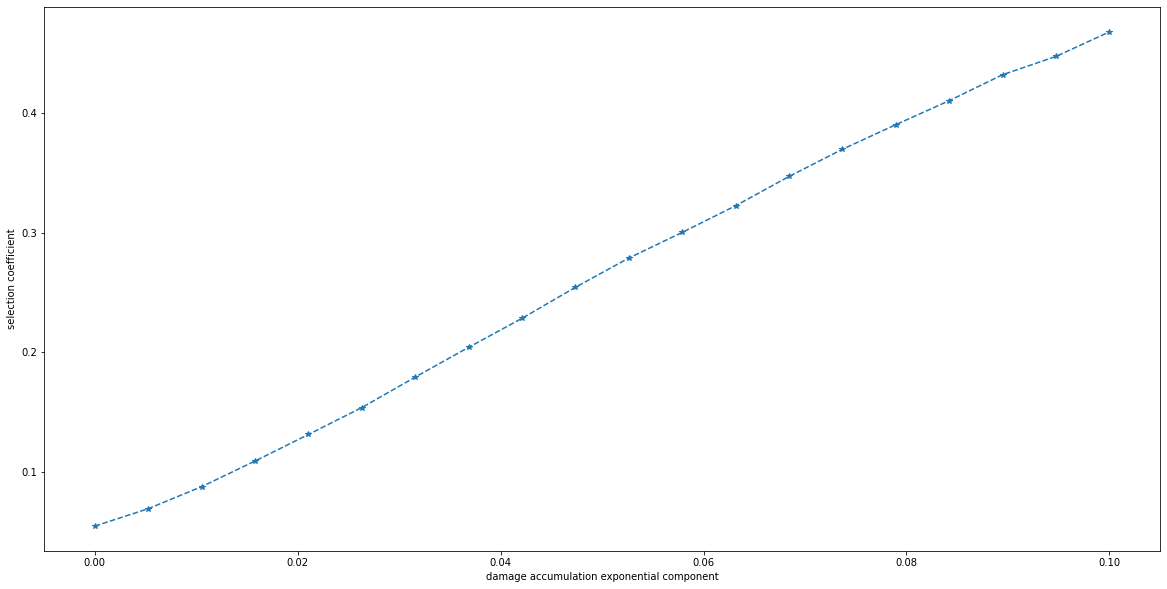

In [27]:
plt.subplots(figsize=(20, 10))
plt.plot(daecs, 1 - np.array(fitness_s)/np.array(fitness_a), marker="*", linestyle="--")
plt.xlabel('damage accumulation exponential component')
plt.ylabel('selection coefficient')

# Hardcore selection coefficient

In [21]:
def prob_to_reproduce_at_age_x(prob, x, N, damage, reproduction_damage_dependence=True):
    if damage <= Cell.lethal_damage_threshold:
        if Cell.damage_survival_dependency == "linear":
            return prob * (1 - damage/Cell.lethal_damage_threshold)*prob_to_reproduce(N, damage, x, damage_dependence=reproduction_damage_dependence)
        else:
            return prob * prob_to_reproduce(N, damage, x, damage_dependence=reproduction_damage_dependence)
    else:
        return 0

def probs_to_reproduce_at_any_age(N, starting_damage, reproduction_damage_dependence=True):
    probs = [1]
    probs_not = [1]
    damages = []
    age = 0
    damage = starting_damage
    while damage < Cell.lethal_damage_threshold:
        age += 1
        damage += (Cell.damage_accumulation_exponential_component * damage
                    + Cell.damage_accumulation_linear_component) 
        if damage >= Cell.lethal_damage_threshold:
            break
        probs_not.append(prob_not_to_reproduce_at_age_x(probs_not[-1], age, N, reproduction_damage_dependence=reproduction_damage_dependence)
        probs.append(prob_to_reproduce_at_age_x(probs_not[-1], age, N, damage, reproduction_damage_dependence=reproduction_damage_dependence))
        damages.append(damage)
    probs.pop(0)
    return probs, damages
    

In [30]:
def generate_damages_for_the_life(starting_damage, max_age):
    damages = [starting_damage]
    for i in range(max_age):
        damages.append(damages[-1] + Cell.damage_accumulation_exponential_component*damages[-1] + Cell.damage_accumulation_linear_component)
    return damages[1:]
        
def probs_to_reproduce_at_any_age(N, starting_damage, reproduction_damage_dependence=True):
    deltas = [1e-300, 1e-100]
    ps = [0, 0]
    x = 0
    p_not = 1
    damage = starting_damage
    while deltas[1] > 1e-20 or deltas[0] < deltas[1]:
        x += 1
        damage += (Cell.damage_accumulation_exponential_component * damage
                    + Cell.damage_accumulation_linear_component) 
        ps.append(prob_to_reproduce_at_age_x(p_not, x, N, damage,  reproduction_damage_dependence=reproduction_damage_dependence))  
        p_not = prob_not_to_reproduce_at_age_x(p_not, x, N, damage, reproduction_damage_dependence=reproduction_damage_dependence)
        deltas = [deltas[1], abs(ps[-1]-ps[-2])]
    return ps[2:]


In [32]:
starting_damage = 0
expected_cell_numbers = probs_to_reproduce_at_any_age(1, starting_damage)
vectors = []
for prob in expected_cell_numbers:
    parallel_vector = probs_to_reproduce_at_any_age(p)*prob

60

In [20]:
prob_to_reproduce_at_all(1, 0)

0.534170123832511

In [23]:
sum(pp)

9.169420149290384e-07

### Simulation-based measurement of growth rate


In [8]:
from ChemostatSimulation import SimulationThread
import tqdm
import pandas as pd
from pathlib import Path
from scipy.stats import gamma
import matplotlib.pyplot as plt
import numpy as np
import os
from ChemostatSimulation import Cell, Chemostat, PRECISION
import datetime
Cell.lambda_large_lookup = Cell.load_lookup_table_for_lambda_large()

In [102]:
popsizes = []

In [116]:
n_steps = 1000
for _ in tqdm.notebook.tqdm(range(800)):
    chemostat = Chemostat(1000000000000000000000000, 0, 
                          n_cells=1, 
                          asymmetry=0)
    simulation = SimulationThread(0, "", 1, chemostat, 0, "", "cluster", False, False)
    np.random.seed((os.getpid() * int(datetime.datetime.now().timestamp()) % 123456789))
    popsize_history = []
    for i in range(n_steps):
        simulation._step(i)
        popsize_history.append(simulation.chemostat.N)
    popsizes.append(popsize_history)

  0%|          | 0/800 [00:00<?, ?it/s]

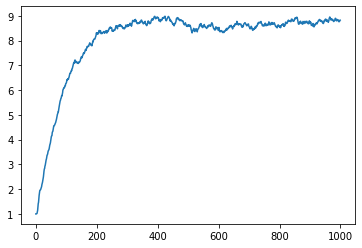

In [78]:
means = np.array(popsizes).mean(axis=0)
plt.plot(means)

In [101]:
len(popsizes)

1029

In [121]:
save = popsizes[:]

In [122]:
popsizes = list(filter(lambda el: 0 not in el, popsizes))

  0%|          | 0/1494 [00:00<?, ?it/s]

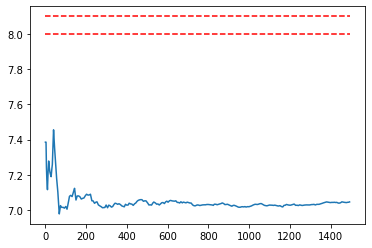

In [123]:
mean_saturation = []
for i in tqdm.notebook.tqdm(range(1, len(popsizes))):
    np.array(popsizes[:i]).mean(axis=0).mean()
    mean_saturation.append(np.array(popsizes[:i]).mean())

plt.plot(mean_saturation)
plt.plot([0, len(mean_saturation)], [8, 8], color="red", linestyle="--")
plt.plot([0, len(mean_saturation)], [8.1, 8.1], color="red", linestyle="--")


In [125]:
symmetric = mean_saturation[:]

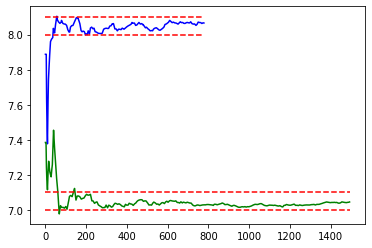

In [128]:
plt.plot(asymmetric, color="blue", label="asymmetric")
plt.plot(symmetric, color="green", label="symmetric")
plt.plot([0, len(asymmetric)], [8, 8], color="red", linestyle="--")
plt.plot([0, len(asymmetric)], [8.1, 8.1], color="red", linestyle="--")
plt.plot([0, len(symmetric)], [7, 7], color="red", linestyle="--")
plt.plot([0, len(symmetric)], [7.1, 7.1], color="red", linestyle="--")


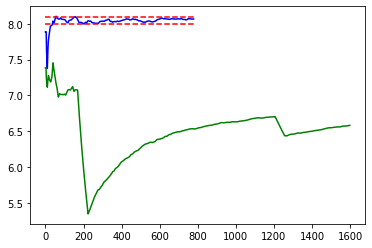

In [119]:
plt.plot(asymmetric, color="blue", label="asymmetric")
plt.plot(symmetric, color="green", label="symmetric")
plt.plot([0, len(asymmetric)], [8, 8], color="red", linestyle="--")
plt.plot([0, len(asymmetric)], [8.1, 8.1], color="red", linestyle="--")

In [108]:
mean_saturation[-50:]

[6.527168,
 6.528439414114514,
 6.52970744680851,
 6.530033200531208,
 6.530358090185676,
 6.530682119205298,
 6.531005291005291,
 6.531327608982827,
 6.531649076517151,
 6.531945981554677,
 6.532242105263158,
 6.532537450722733,
 6.532832020997375,
 6.533125819134994,
 6.533418848167539,
 6.533711111111111,
 6.534436031331593,
 6.535159061277706,
 6.535880208333333,
 6.536599479843953,
 6.537316883116883,
 6.53803242542153,
 6.537268134715026,
 6.5365058214747735,
 6.5357454780361754,
 6.534987096774193,
 6.534230670103093,
 6.533476190476191,
 6.532723650385604,
 6.532673940949936,
 6.532624358974359,
 6.53257490396927,
 6.53252557544757,
 6.5324763729246484,
 6.532427295918367,
 6.532378343949045,
 6.532888040712468,
 6.533396442185515,
 6.533903553299492,
 6.53440937896071,
 6.534913924050633,
 6.535417193426043,
 6.53647601010101,
 6.537532156368222,
 6.53858564231738,
 6.539636477987421,
 6.540684673366834,
 6.541730238393978,
 6.543048872180451,
 6.544364205256571]

## Simplified symmetric/asymmetric comparison


In [55]:
# Similar to my simulation with:
# dsd = threshold
# linear damage accumulation (dalc = d)
# probability of division is independent of damage

In [109]:
class Population:
    def __init__(self, a, d):
        self.cells = [0]*10
        self.a = a
        self.h = [len(self.cells)]
        self.d = d
    def step(self):
        for i in range(len(self.cells)):
            self.cells[i] += self.d
        life_cells = []
        for i in range(len(self.cells)):
            if self.cells[i] < 1 or np.random.uniform() < 0.5:
                life_cells.append(self.cells[i])
        new_cells = []
        for cell in life_cells:
            new_cells.extend([(cell)*(1+self.a)/2, (cell)*(1-self.a)/2])
        new_cells = list(filter(lambda el: el <= 1, new_cells))
        self.cells = new_cells
        self.h.append(len(self.cells))
        
    def run(self, n_steps):
        for _ in range(n_steps):
            self.step()

In [91]:
# So far reproducing Nash's notes

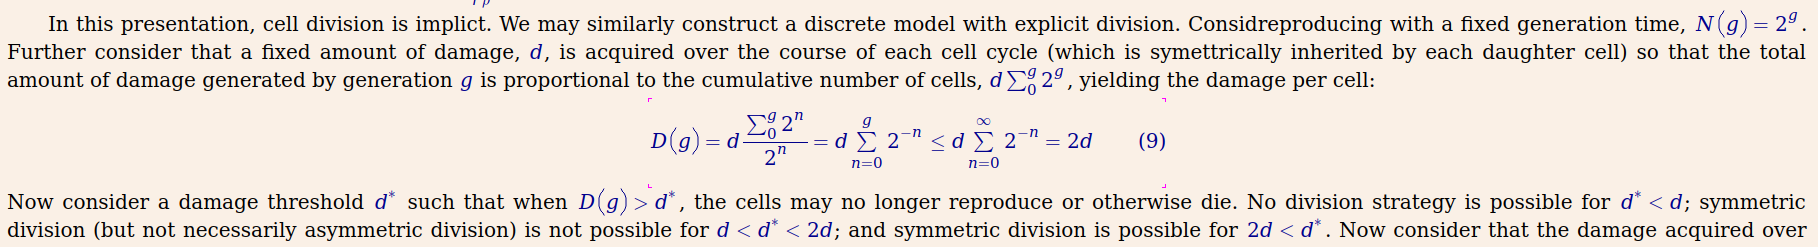

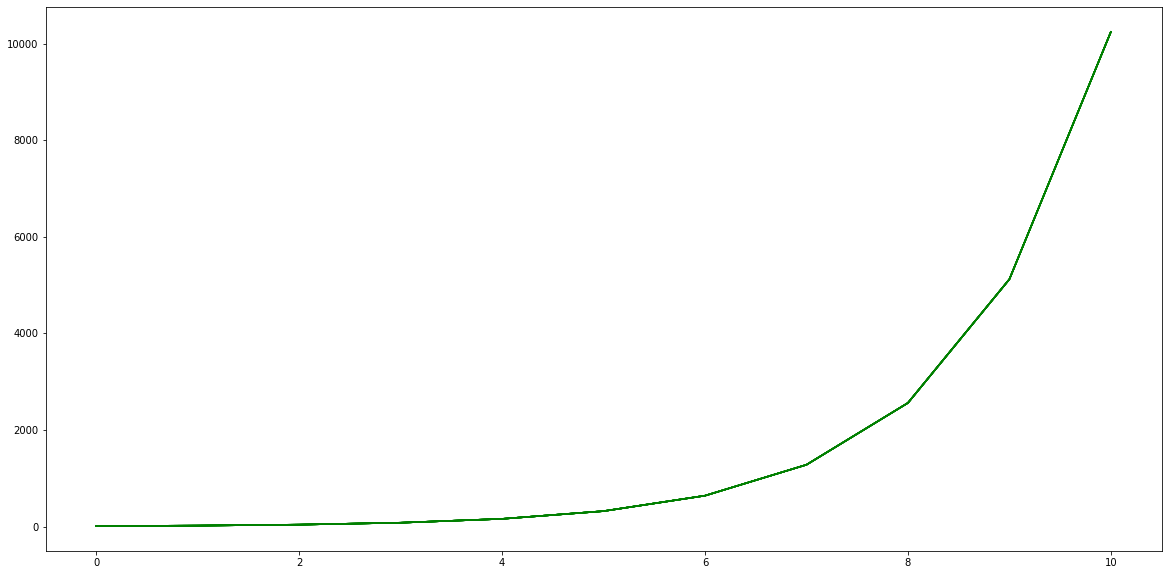

In [106]:
# For d < 0.5 population lives
plt.subplots(figsize=(20, 10))
for _ in range(10):
    s = Population(a=0, d=0.1)
    s.run(10)
    a.run(10)
    plt.plot(s.h, color="green")

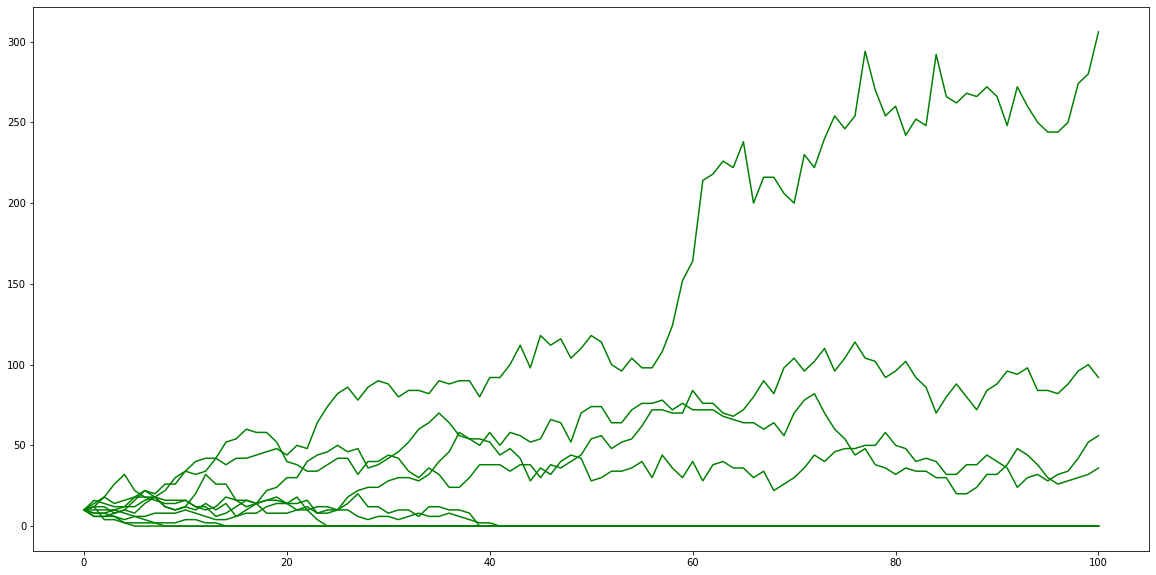

In [102]:
# For d > 0.5 ~ population dies
plt.subplots(figsize=(20, 10))
for _ in range(10):
    s = Population(a=0, d=0.9)
    s.run(100)
    a.run(100)
    plt.plot(s.h, color="green")

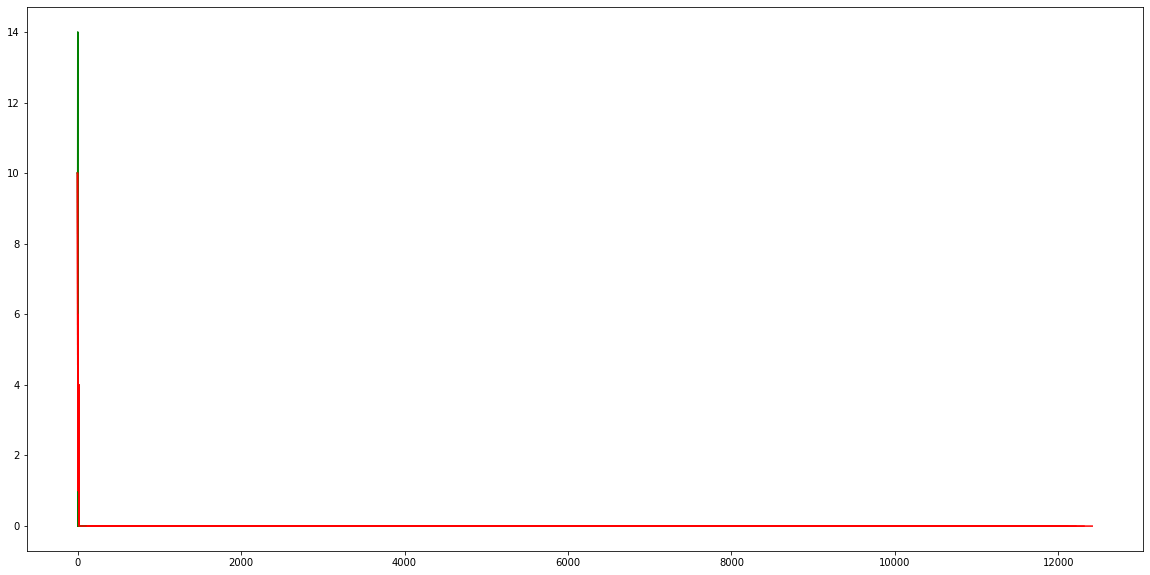

In [108]:
# For d > 1 ~ no division strategy is possible
plt.subplots(figsize=(20, 10))
for _ in range(10):
    s = Population(a=0, d=1.5)
    s.run(100)
    a.run(100)
    plt.plot(s.h, color="green")
    plt.plot(a.h, color="red")
    

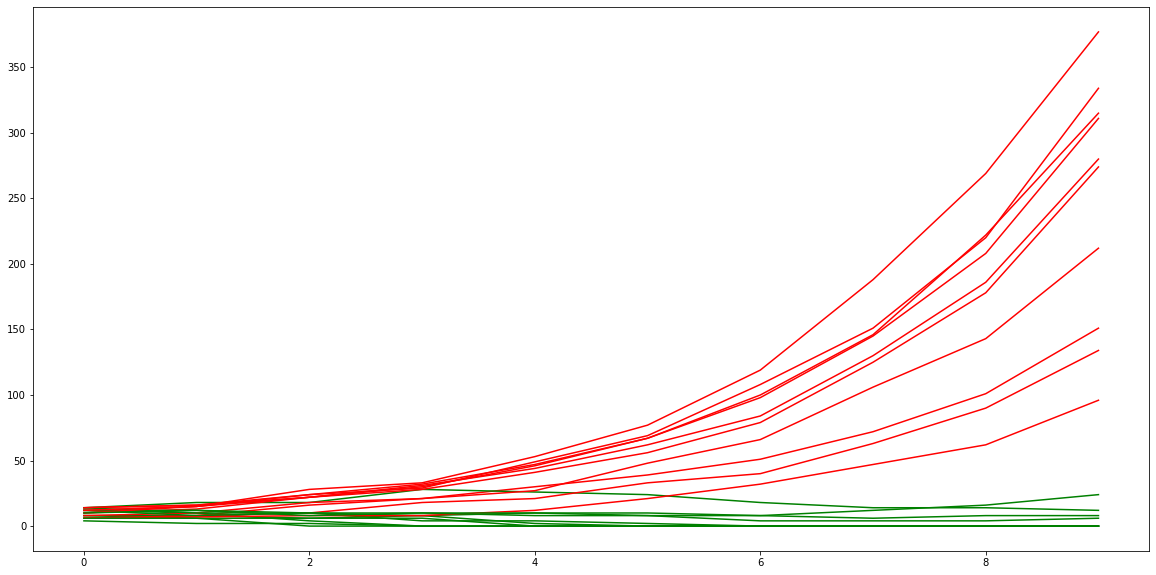

In [52]:
# When d = 0.5 
# symmetric cells experience random walk around their initial popsize (their expected number of 
# offspring is 1)
# asymmetric cells outgrow them because they have an increasing population of cells that never die because of damage 
plt.subplots(figsize=(20, 10))
for _ in range(10):
    s = Population(a=0, d=0.5)
    a = Population(a=1, d=0.5)
    s.run(10)
    a.run(10)
    plt.plot(a.h, color="red")
    plt.plot(s.h, color="green")

In [69]:
dd

array([ 1.        ,  1.10069417,  1.21152766,  1.33352143,  1.46779927,
        1.6155981 ,  1.77827941,  1.95734178,  2.15443469,  2.37137371,
        2.61015722,  2.87298483,  3.16227766,  3.48070059,  3.83118685,
        4.21696503,  4.64158883,  5.10896977,  5.62341325,  6.18965819,
        6.81292069,  7.49894209,  8.25404185,  9.08517576, 10.        ])

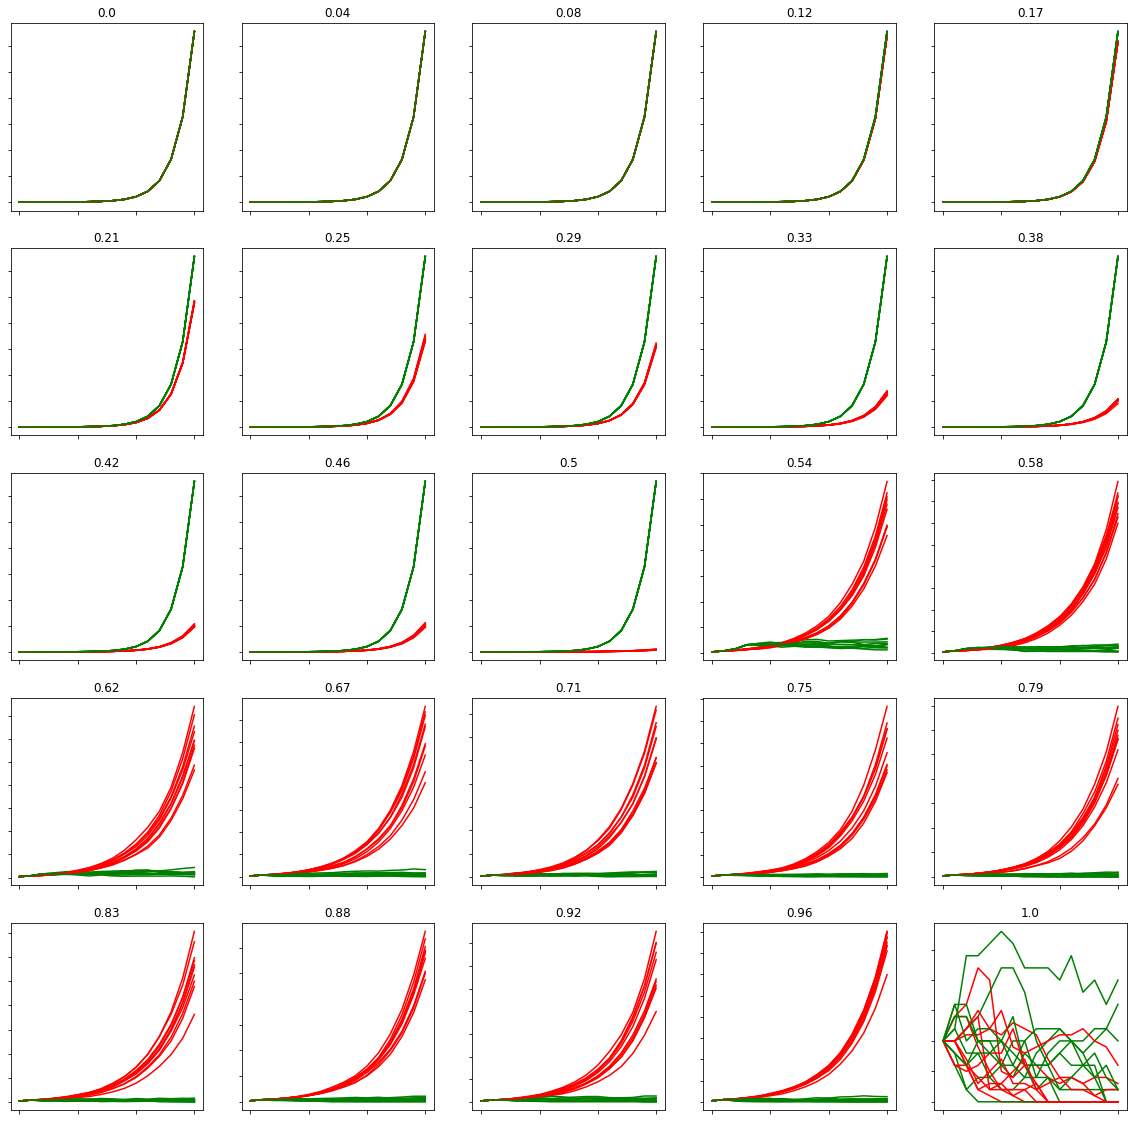

In [110]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
dd = np.logspace(-5, 0, 25)
dd = np.linspace(0, 1, 25)

for i in range(25):
    axis = ax[i//5, i%5]
    axis.set_yticklabels([])
    axis.set_xticklabels([])
    for _ in range(10):
        d = dd[i]
        s = Population(a=0, d=d)
        a = Population(a=1, d=d)
        s.run(15)
        a.run(15)
        axis.plot(a.h, color="red")
        axis.plot(s.h, color="green")
    axis.set_title(round(d, 2))

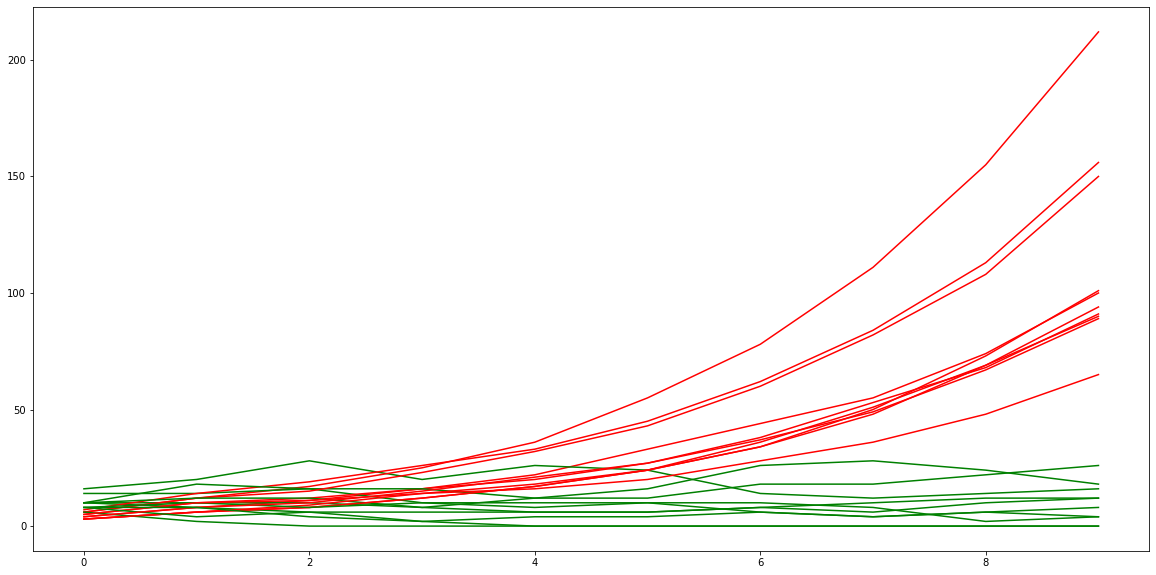

In [65]:
# When d < 0.5
# no cells of symmetric population ever die of damage as the damage is only diluted
# but some cells of asymmetric populatino die of damage as they accumulate it 
# -> asymmetry is disfavoured
plt.subplots(figsize=(20, 10))
for _ in range(10):
    s = Population(a=0, d=d)
    a = Population(a=1, d=d)
    s.run(10)
    a.run(10)
    plt.plot(a.h, color="red")
    plt.plot(s.h, color="green")